# IRMDP: Homework 7.1

## Importing of classes and necessary setting as in testSensitivity.py

In [1]:
import sys, os, io, copy, time
if locals().get('__file__'):
    sys.path.append(os.path.join(os.path.dirname(__file__),'QuantLibWrapper'))
else:
    sys.path.append(os.path.join(os.getcwd(),'QuantLibWrapper'))
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import pandas

import QuantLib as ql
import QuantLibWrapper.YieldCurve as yc

from QuantLibWrapper import HullWhiteModel, MCSimulation, Payoffs, BermudanOption, \
                            DensityIntegrationWithBreakEven, SimpsonIntegration, \
                            HermiteIntegration, CubicSplineExactIntegration, \
                            PDESolver, AMCSolver, \
                            AMCSolverOnlyExerciseRegression, \
                            HullWhiteModelWithDiscreteNumeraire 

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
# yield curves
flatCurve = yc.YieldCurve(['30y'],[0.03])
terms = [    '1y',    '2y',    '3y',    '4y',    '5y',    '6y',    '7y',    '8y',    '9y',   '10y',   '12y',   '15y',   '20y',   '25y',   '30y' ] 
rates = [ 2.70e-2, 2.75e-2, 2.80e-2, 3.00e-2, 3.36e-2, 3.68e-2, 3.97e-2, 4.24e-2, 4.50e-2, 4.75e-2, 4.75e-2, 4.70e-2, 4.50e-2, 4.30e-2, 4.30e-2 ] 
fwdRateYC = yc.YieldCurve(terms,rates)

# Hull-White model

meanReversion    = 0.05
volatilityTimes  = np.array([  1.0 , 2.0 , 5.0 , 10.0  ])
volatilityValues = np.array([  0.01, 0.01, 0.01,  0.01 ])

hwModel          = HullWhiteModelWithDiscreteNumeraire(fwdRateYC,meanReversion,volatilityTimes,volatilityValues)
hwModel = HullWhiteModel(fwdRateYC,meanReversion,volatilityTimes,volatilityValues)
times  = np.linspace(0.0,20.0,21)
#times  = np.array([ k for k in range(1,21)])
#method  = MCSimulation(hwModel,times,nPaths)
#method = AMCSolver(mcSim,3,0.25)

In [3]:
exercise  = 10.0
payTimes  = [ 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 20.0 ]
cashFlows = [ -1.0] + list(np.repeat(0.03,len(payTimes) - 2)) + [1.0 ]

print('Bond option with zero strike: ' + str(hwModel.couponBondOption(exercise,payTimes,cashFlows,0.0,1.0)))
print('Bond option with unit strike: ' + str(hwModel.couponBondOption(exercise,payTimes[1:],cashFlows[1:],1.0,1.0)))

Bond option with zero strike: 0.012918917742441277
Bond option with unit strike: 0.012918917742441277


In [26]:
     
def MC_path(nPaths,expiry = 10.0,meanReversion=0.05,vol=0.01):
    hwModel = HullWhiteModel(fwdRateYC,meanReversion,volatilityTimes,np.repeat(vol,len(volatilityTimes)))
    expiryTimes = np.array([ expiry])
    if expiry<10:underlyings = [Payoffs.Zero()]
    else:underlyings = [Payoffs.CouponBond(hwModel,expiryTimes[0],payTimes,cashFlows) ]
    payoff = Payoffs.Pay(Payoffs.VanillaOption(Payoffs.CouponBond(hwModel,expiryTimes[0],payTimes,cashFlows),0.0,1.0),expiryTimes[0])
    times  = list(np.linspace(0,20,21))
    price = hwModel.couponBondOption(expiry,payTimes,cashFlows,0.0,1.0)
    ret = np.array([[n,abs(MCSimulation(hwModel,times,n).npv(payoff)/price-1)] for n in nPaths])
    return ret

In [29]:
nPaths = list(np.geomspace(100,25000,15,dtype=int))
nPaths

[100,
 148,
 220,
 326,
 484,
 718,
 1065,
 1581,
 2345,
 3479,
 5161,
 7657,
 11359,
 16852,
 24999]

In [30]:
%%timeit -r 1
%%capture
ret_a = {}
for i in [5.0,8.0,10.0]:
    tmp_mcPrice = MC_path(nPaths, expiry=i)
    ret_a.update({i:tmp_mcPrice})

5min 49s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


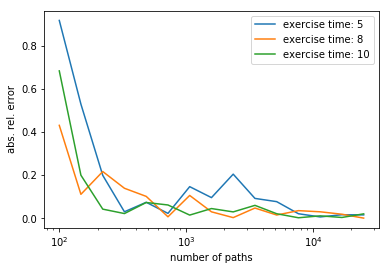

In [33]:
for k,v in ret_a.items():
    plt.semilogx(v[:,0],v[:,1],label='exercise time: %i'%k)
plt.xlabel('number of paths')
plt.ylabel('abs. rel. error')
plt.legend()
plt.show()
ret_a

price = hwModel.couponBondOption(max(payTimes),payTimes,cashFlows,0.0,1.0)


In [8]:
%%timeit -r 1
%%capture
nPaths = list(np.geomspace(250,25000,15,dtype=int))
ret = {}
mrs = [-0.05,0.0001,0.05]
for mr in mrs:
    for vol in [0.005,0.01,0.02]:
        tmp_mcPrice = MC_path(nPaths,meanReversion=mr,vol=vol)
        ret.update({(mr,vol):tmp_mcPrice})

21min 43s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


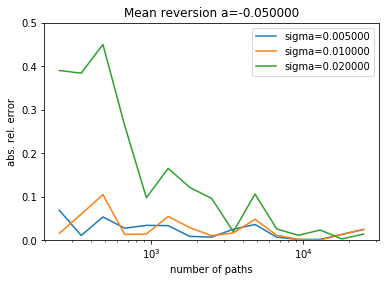

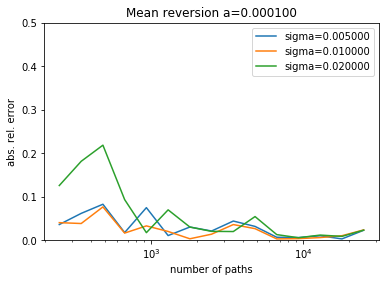

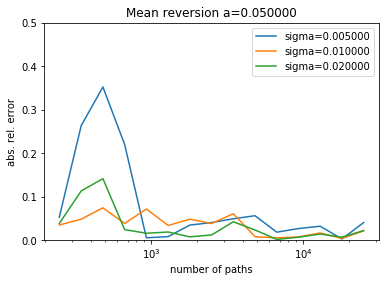

In [11]:

for mr in mrs: 
    tmp = {k:v for k,v in ret.items() if k[0]==mr}
    for k,v in tmp.items():
        plt.semilogx(v[:,0],v[:,1],label='sigma=%f'%k[1])
    plt.xlabel('number of paths')
    plt.ylabel('abs. rel. error')
    plt.ylim([0,0.5])
    plt.title('Mean reversion a=%f'%mr)
    plt.legend()
    plt.show()